In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.linalg as la

from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader
import time
from gensim.models import Word2Vec
from collections import defaultdict
from utils.preprocess import add_fragments
from molecules.conversion import (
    mols_from_smiles, mol_to_smiles, mols_to_smiles, canonicalize)

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit.Chem import MolToSmiles, MolFromSmiles
from copy import deepcopy
from molecules.fragmentation import fragment_recursive
from molecules.fragmentation import reconstruct
import json
import random
from rdkit.Chem import Draw
import math
import scipy.stats
from scipy.stats import norm
import time
import random
import gc
from molecules.fragmentation import join_molecules
from rdkit.Chem import Crippen, QED
from molecules.sascorer.sascorer import calculateScore
from sklearn.metrics import r2_score
from IPython.display import clear_output

# Load Model

In [2]:
# paste the file directory from your local storage, it is vital that for the model selected, you edit the model name, for example: 
# 2022-11-24@143425-LAPTOP-E1483HNR-CHEMBL-logP-SAS-recurse-r-short-1-layer-decode-01-KL-20-epoch-100-hidden-size-OUR-MODEL
# becomes: '2022-11-24@143425-LAPTOP-E1483HNR-CHEMBL' in the local storage
# replace the  symbol with ':' and then simply paste that in the directory below:
file_dir = 'RUNS/2024-02-01@22-24-09-LAPTOP-E1483HNR-ZINC/'
#file_dir = 'RUNS/2024-01-28@00-51-02-LAPTOP-E1483HNR-ZINC/'
config = pickle.load(open(file_dir + 'config/config.pkl', "rb"))
vocab = pickle.load(open(file_dir + 'config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
load_last = True
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

Vocab created/loaded. Size: 646. Effective size: 646. Time elapsed: 00:00:00.


c:\Users\panuk\anaconda3\envs\fragment-vae\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


loading last.pt at epoch 5...


In [3]:
model

Frag2Mol(
  (embedder): Embedding(646, 100)
  (latent2rnn): Linear(in_features=100, out_features=100, bias=True)
  (encoder): Encoder(
    (rnn): GRU(100, 100, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=100, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=100, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 100, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=100, out_features=646, bias=True)
  )
  (mlp): MLP(
    (layers_qed): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): ReLU()
      (4): Sigmoid()
    )
    (layers_logp): Sequential(
      (0): Linear(in_features=100, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=1, bias=True)
    )
    (layers_sas): Seque

# Running the training set through the model for latent space and box plots

In [55]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
data_sample_correct = []
#rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 38023. Time elapsed: 00:00:00.


In [56]:
#run the training set through the final model
counter = 0
for idx, (src, tgt, lengths, data, tgt_str) in enumerate(loader):
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()
    
    output, mu, sigma, z, pred_logp, pred_sas = model.forward(src, lengths)
    
    #get correct id
    tgt_str_lst = [vocab.translate(target_i) for target_i in tgt.cpu().detach().numpy()]
    target_str_ls_2 = [" ".join(vocab.translate(target_i)) for target_i in tgt.cpu().detach().numpy()]
    src_str_ls_2 = [vocab.translate(target_i) for target_i in src.cpu().detach().numpy()]
    molecules = dataset.data.iloc[list(data)]
    data_index_correct = [molecules[molecules['fragments'] == target_str_ls_2_i].index.values[0] for target_str_ls_2_i in target_str_ls_2]
    molecules_correct = dataset.data.iloc[data_index_correct]
    data_sample_correct.append(data_index_correct)
            
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        z_stack = z[0]
        mu_stack = mu
        pred_logp_stack = pred_logp
        pred_sas_stack = pred_sas
    else:
        z_stack = torch.cat((z_stack,z[0]),0)
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_logp_stack = torch.cat((pred_logp_stack, pred_logp), 0)
        pred_sas_stack = torch.cat((pred_sas_stack, pred_sas), 0)
    counter += 1
    if counter % 500 == 0:
        print(len(mu_stack))
        torch.cuda.empty_cache()

8000
16000
24000
32000


In [57]:
z[0].size()

torch.Size([7, 100])

In [58]:
src_str_ls_2

[['*OC', '*c1ccc(F)c(*)c1', '*C(*)C', '*[NH2+]*', '*C(*)C', '*c1cccc(F)c1F'],
 ['*CC',
  '*Nc1cc(*)nn1C',
  '*C(=O)C(*)=O',
  '*N*',
  '*C(*)C',
  '*c1ccc(-n2cccn2)cc1'],
 ['*OC',
  '*Nc1cc(F)ccc1*',
  '*C(=O)C(*)=O',
  '*N*',
  '*CCC(*)C',
  '*c1ccc(F)c(F)c1'],
 ['*N(C)C', '*c1cccc(*)c1', '*CC(=O)NNC(*)=O', '*c1ccc(*)cc1', '*OC(F)F'],
 ['*OC', '*CCC(*)=O', '*S*', '*c1cc(C)on1', '*CC(=O)N*'],
 ['*CC', '*[NH2+]*', '*c1ccc(C)s1', '*C(*)*', '*C1CN2CCCC2CO1'],
 ['*c1cc(C)ccc1F', '*C(*)=O', '*N*', '*C(*)CC', '*c1nc(C)n[nH]1']]

In [59]:
molecules_correct

,smiles,fragments,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,logP,mr,qed,SAS
18247,COc1cc(C(C)[NH2+]C(C)c2cccc(F)c2F)ccc1F,*OC *c1ccc(F)c(*)c1 *C(*)C *[NH2+]* *C(*)C *c1...,6,17,3,1,1,0,17,6,0,0,0,0,2,3.49810,78.0654,0.898488,3.682795
25918,CCc1cc(NC(=O)C(=O)NC(C)c2ccc(-n3cccn3)cc2)n(C)n1,*CC *Nc1cc(*)nn1C *C(=O)C(*)=O *N* *C(*)C *c1c...,6,19,0,6,2,0,20,9,0,0,0,2,1,1.98410,101.3374,0.675372,2.930267
23761,COc1ccc(F)cc1NC(=O)C(=O)NC(C)CCc1ccc(F)c(F)c1,*OC *Nc1cc(F)ccc1* *C(=O)C(*)=O *N* *CCC(*)C *...,6,19,3,2,3,0,20,8,0,0,0,0,2,3.18850,93.8654,0.756713,2.545217
9997,CN(C)c1cccc(C(=O)NNC(=O)Cc2ccc(OC(F)F)cc2)c1,*N(C)C *c1cccc(*)c1 *CC(=O)NNC(*)=O *c1ccc(*)c...,5,18,2,3,3,0,19,8,0,0,0,0,2,2.35770,93.1559,0.773305,2.071495
22161,COC(=O)CCSCC(=O)Nc1cc(C)on1,*OC *CCC(*)=O *S* *c1cc(C)on1 *CC(=O)N*,5,10,0,2,4,1,13,4,0,0,0,1,0,1.21782,63.8277,0.609981,2.266045
27701,CC[NH2+]C(c1ccc(C)s1)C1CN2CCCC2CO1,*CC *[NH2+]* *c1ccc(C)s1 *C(*)* *C1CN2CCCC2CO1,5,15,0,2,1,1,19,2,0,0,0,2,1,1.54412,78.5984,0.906988,4.583957
22455,CCC(NC(=O)c1cc(C)ccc1F)c1nc(C)n[nH]1,*c1cc(C)ccc1F *C(*)=O *N* *C(*)CC *c1nc(C)n[nH]1,5,14,1,4,1,0,15,6,0,0,0,1,1,2.44174,72.7549,0.900663,3.012269


In [60]:
z_stack_test[:,0]

NameError: name 'z_stack_test' is not defined

## Training set

In [61]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]
data_sample_index_correct_pd = pd.DataFrame(data_sample_index_correct)
data_sample_index_correct_pd.to_csv(file_dir + 'data_sample_index_correct.csv', index=False)

In [62]:
torch.save(mu_stack.detach(), file_dir + 'mu_stack_tensor.pt')
torch.save(z_stack.detach(), file_dir + 'z_stack_tensor.pt')
torch.save(pred_sas_stack.detach(), file_dir + 'pred_sas_stack.pt')
torch.save(pred_logp_stack.detach(), file_dir + 'pred_logp_stack.pt')

In [63]:
# run this cell if we already have the saved files
mu_stack = torch.load(file_dir + 'mu_stack_tensor.pt')
z_stack = torch.load(file_dir + 'z_stack_tensor.pt')
pred_sas_stack = torch.load(file_dir + 'pred_sas_stack.pt')
pred_logp_stack = torch.load(file_dir + 'pred_logp_stack.pt')
data_sample_index_correct_pd = pd.read_csv(file_dir + 'data_sample_index_correct.csv')
data_sample_index_correct = list(data_sample_index_correct_pd.iloc[:,0])

In [64]:
torch.mean(z_stack[0])
torch.std(z_stack[1])

tensor(0.0334, device='cuda:0')

In [65]:
torch.Tensor.size(z_stack)

torch.Size([38023, 100])

In [66]:
df_predicted_train = pd.DataFrame({'Predicted SAS':pred_sas_stack.detach().cpu().numpy(), 'Predicted LogP':pred_logp_stack.detach().cpu().numpy()})
df_predicted_train

,Predicted SAS,Predicted LogP
0,2.822697,2.442339
1,2.815306,2.451648
2,2.821412,2.456577
3,2.827228,2.454542
4,2.812893,2.444076
...,...,...
38018,2.807914,2.453928
38019,2.824857,2.457361
38020,2.819948,2.457623
38021,2.824288,2.452120


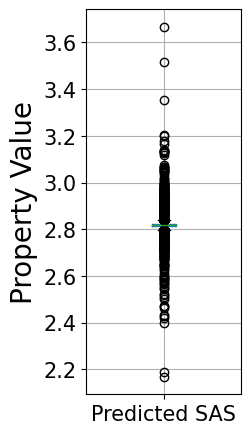

In [67]:
fig, ax1 = plt.subplots(figsize=(2, 5))
df_predicted_train.boxplot(column=['Predicted SAS'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
#plt.savefig(file_dir + 'Predicted_SAS_Box_Plot_training_set.png', bbox_inches = 'tight')
plt.show()

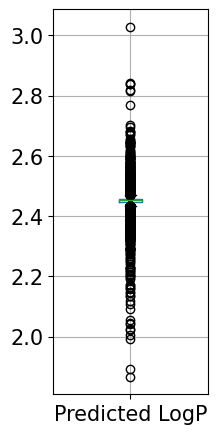

In [68]:
fig, ax1 = plt.subplots(figsize=(2, 5))
df_predicted_train.boxplot(column=['Predicted LogP'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.savefig(file_dir + 'Predicted_logp_Box_Plot_training_set.png', bbox_inches = 'tight')
plt.show()

## Test set

In [69]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]
data_sample_index_correct_pd = pd.DataFrame(data_sample_index_correct)
data_sample_index_correct_pd.to_csv(file_dir + 'data_sample_index_correct_test.csv', index=False)

In [70]:
torch.save(mu_stack.detach(), file_dir + 'mu_stack_tensor_test.pt')
torch.save(z_stack.detach(), file_dir + 'z_stack_tensor_test.pt')
torch.save(pred_sas_stack.detach(), file_dir + 'pred_sas_stack_test.pt')
torch.save(pred_logp_stack.detach(), file_dir + 'pred_logp_stack_test.pt')

In [71]:
mu_stack = torch.load(file_dir + 'mu_stack_tensor_test.pt')
z_stack = torch.load(file_dir + 'z_stack_tensor_test.pt')
pred_sas_stack = torch.load(file_dir + 'pred_sas_stack_test.pt')
pred_logp_stack = torch.load(file_dir + 'pred_logp_stack_test.pt')
data_sample_index_correct_pd = pd.read_csv(file_dir + 'data_sample_index_correct_test.csv')
data_sample_index_correct = list(data_sample_index_correct_pd.iloc[:,0])

In [72]:
df_predicted_test = pd.DataFrame({'Predicted SAS':pred_sas_stack.detach().cpu().numpy(), 'Predicted LogP':pred_logp_stack.detach().cpu().numpy()})
df_predicted_test

,Predicted SAS,Predicted LogP
0,2.822697,2.442339
1,2.815306,2.451648
2,2.821412,2.456577
3,2.827228,2.454542
4,2.812893,2.444076
...,...,...
38018,2.807914,2.453928
38019,2.824857,2.457361
38020,2.819948,2.457623
38021,2.824288,2.452120


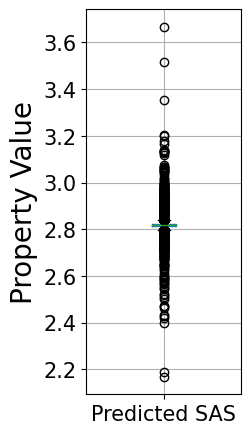

In [73]:
fig, ax1 = plt.subplots(figsize=(2, 5))
df_predicted_test.boxplot(column=['Predicted SAS'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
#plt.savefig(file_dir + 'Predicted_SAS_Box_Plot_test_set.png', bbox_inches = 'tight')
plt.show()

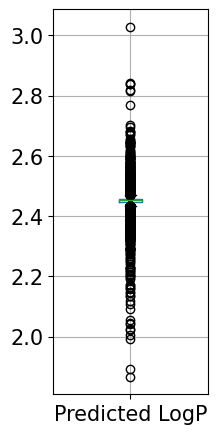

In [74]:
fig, ax1 = plt.subplots(figsize=(2, 5))
df_predicted_test.boxplot(column=['Predicted LogP'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.savefig(file_dir + 'Predicted_logp_Box_Plot_test_set.png', bbox_inches = 'tight')
plt.show()

# Prediction Loss

In [75]:
true_sas_np = np.array(dataset.data.loc[data_sample_index_correct, 'SAS'])
pred_sas_np = np.array(pred_sas_stack.cpu())
sas_np_pred_mse = 1/len(pred_sas_np) *  np.sum((true_sas_np - pred_sas_np)**2)
print("MSE:", sas_np_pred_mse)
print("RMSE:", np.sqrt(sas_np_pred_mse))
print("R2: ", r2_score(true_sas_np, pred_sas_np))

MSE: 0.6690191591191424
RMSE: 0.8179359138215796
R2:  0.0010088107818000402


In [76]:
true_logp_np = np.array(dataset.data.loc[data_sample_index_correct, 'logP'])
pred_logp_np = np.array(pred_logp_stack.cpu())
logp_np_pred_mse = 1/len(pred_logp_np) *  np.sum((true_logp_np - pred_logp_np)**2)
print("MSE:", logp_np_pred_mse)
print("RMSE:", np.sqrt(logp_np_pred_mse))
print("R2: ", r2_score(true_logp_np, pred_logp_np))

MSE: 1.7937609539875468
RMSE: 1.3393136130076282
R2:  0.0026213403968382565


## Plot latent space PCA

In [77]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [78]:
print(np.mean(principalDf['pc1']))
print(np.mean(principalDf['pc2']))

-1.2039125e-08
-2.407825e-09


In [79]:
print(np.std(principalDf['pc1']))
print(np.std(principalDf['pc2']))

2.811915159225464
2.43576979637146


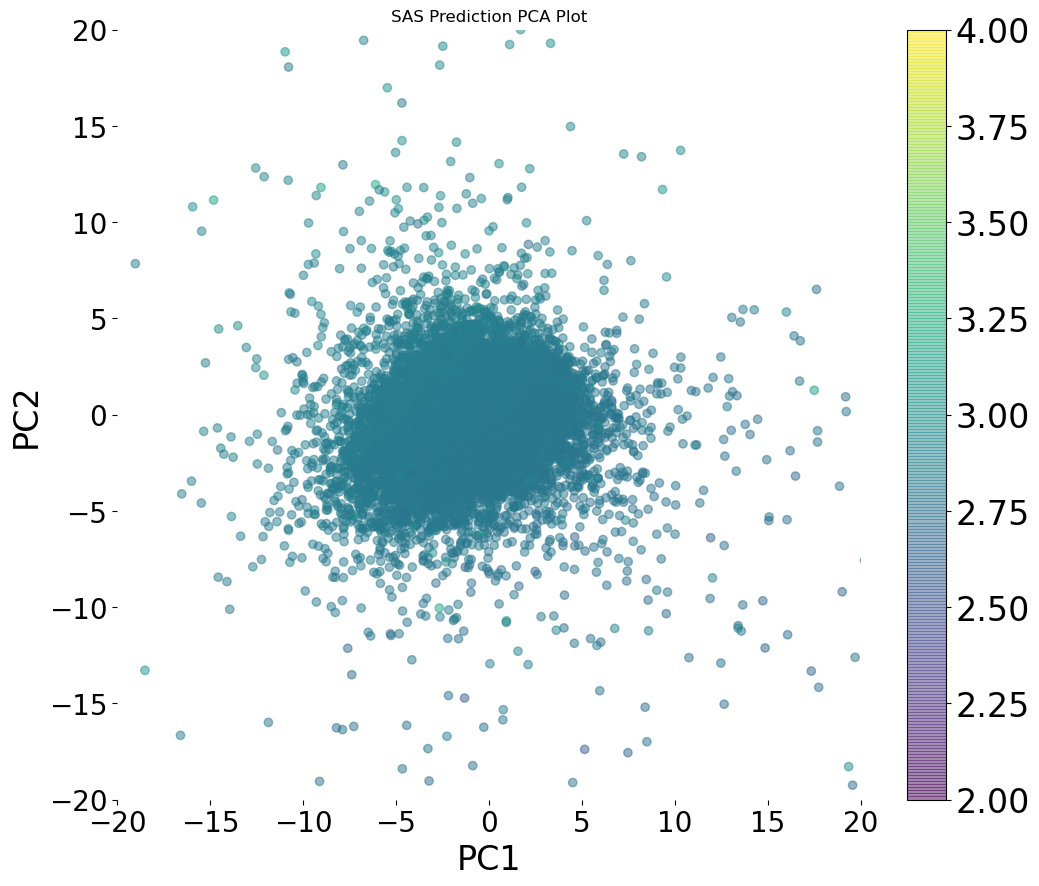

In [80]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=pred_sas_stack.cpu().detach().numpy(),
            vmin = 2, vmax = 4)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
plt.title('SAS Prediction PCA Plot')
#plt.savefig(file_dir + 'Predicted_SAS_PCA_Plot_training_set.png')
plt.show()

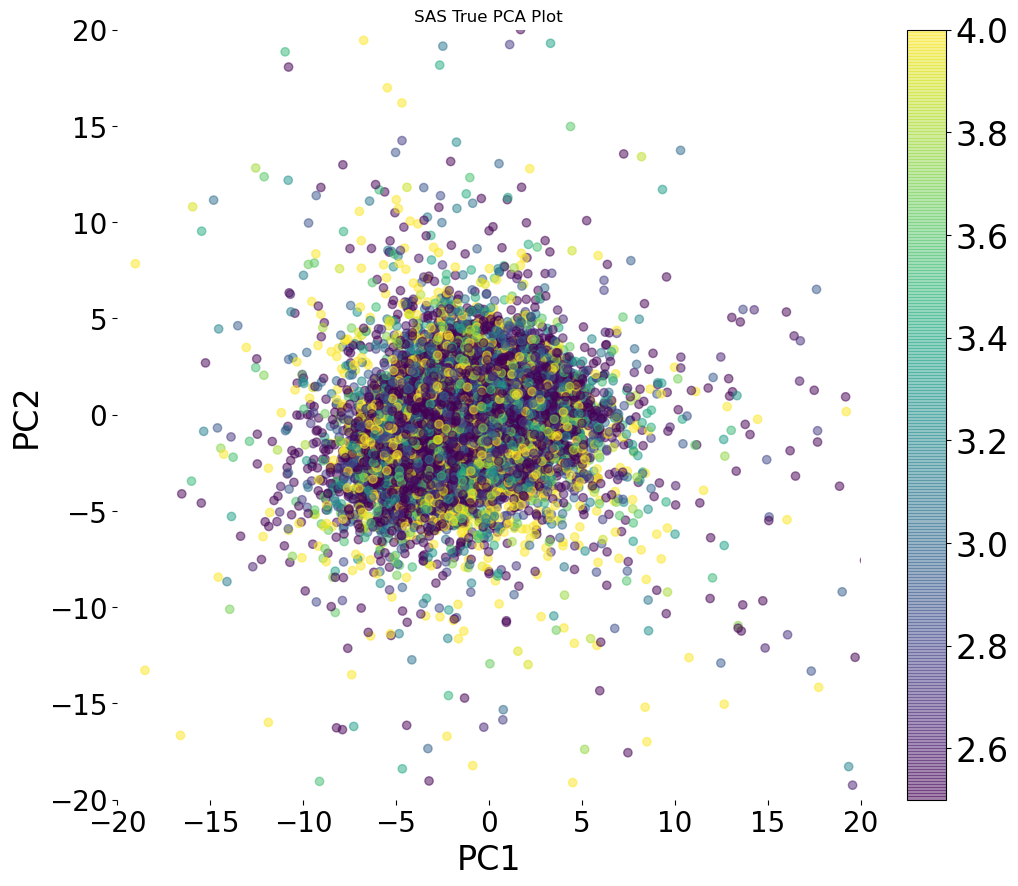

In [81]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'SAS']),
            vmin = 2.5, vmax = 4)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
plt.title('SAS True PCA Plot')
#plt.savefig(file_dir + 'True_SAS_PCA_Plot_training_set.png')
plt.show()

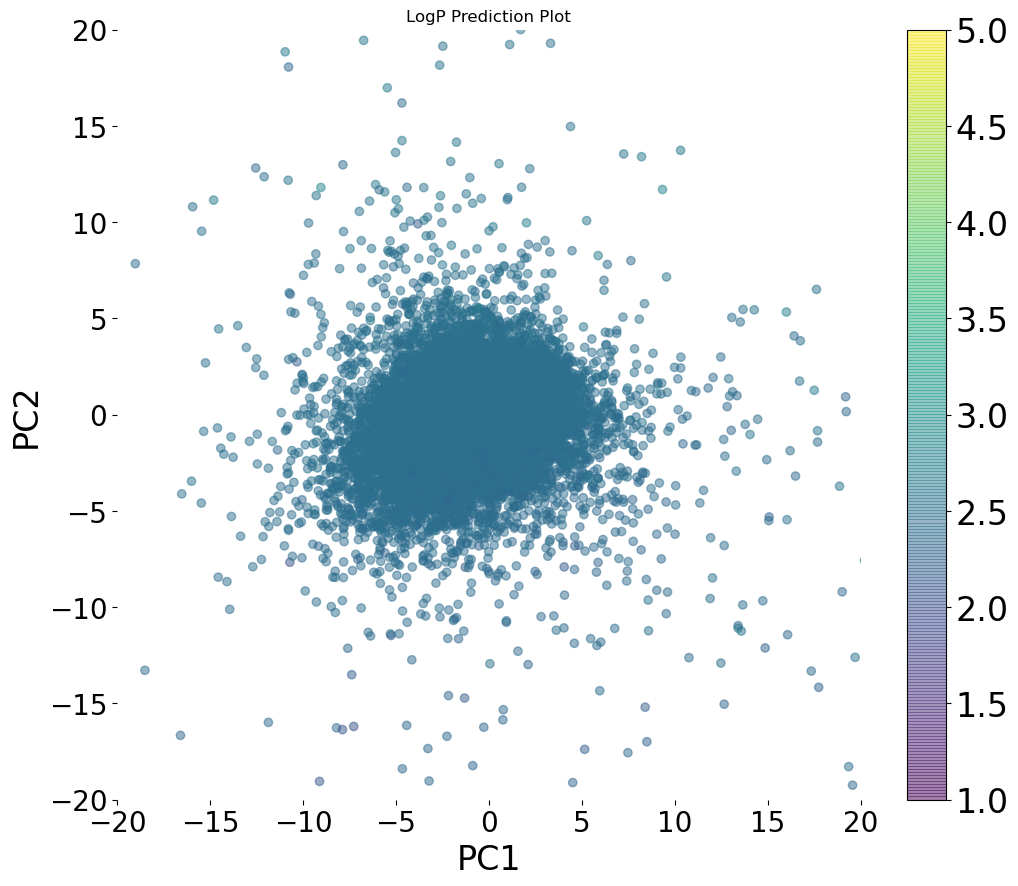

In [82]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=pred_logp_stack.cpu().detach().numpy(),
            vmin = 1, vmax = 5)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
plt.title('LogP Prediction Plot')
#plt.savefig(file_dir + 'Predicted_logp_PCA_Plot_training_set.png')
plt.show()

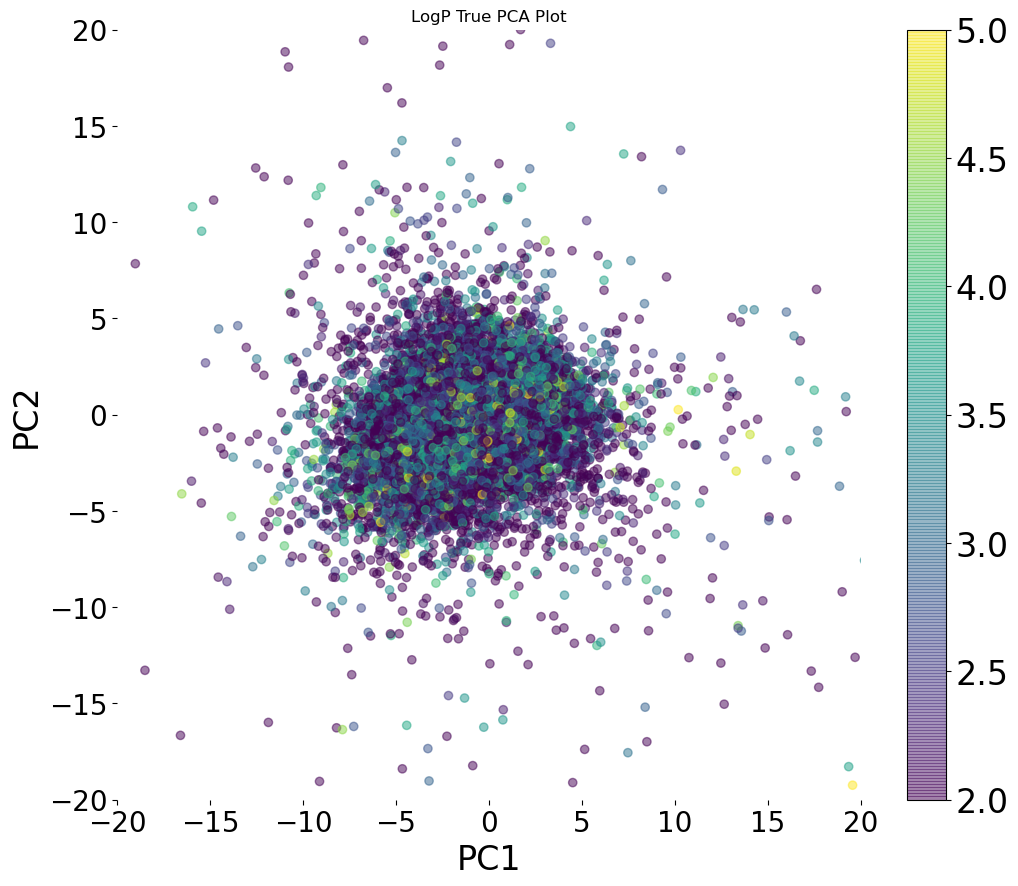

In [83]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'logP']),
            vmin = 2, vmax = 5)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
plt.title('LogP True PCA Plot')
#plt.savefig(file_dir + 'True_logp_PCA_Plot_training_set.png')
plt.show()

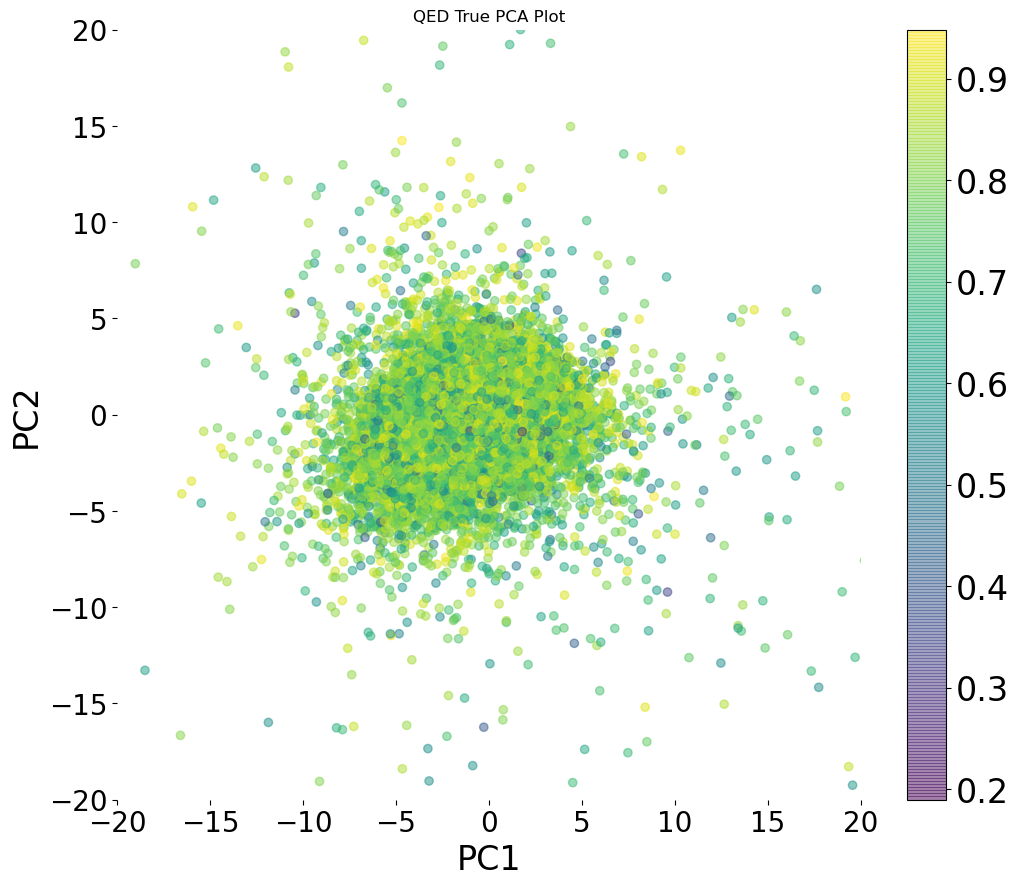

In [84]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(dataset.data.loc[data_sample_index_correct, 'qed']))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.box(on=None)
plt.title('QED True PCA Plot')
#plt.savefig(file_dir + 'True_QED_PCA_Plot_training_set.png')
plt.show()

# Sample valid molecules and plots of the latent space

In [85]:
def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [86]:
# Fragment reconstruction
def replace_last(s, old, new):
    s_reversed = s[::-1]
    old_reversed = old[::-1]
    new_reversed = new[::-1]

    # Replace the first occurrence in the reversed string
    s_reversed = s_reversed.replace(old_reversed, new_reversed, 1)

    # Reverse the string back to original order
    return s_reversed[::-1]

def reconstruct(fragments):
    #print("Reconstructing...")
    frag_recomb_list = []
    frag_2_re = fragments[-1]
    for i in range(len(fragments)-1):
        frag_1_re = fragments[-1*i-2]
        recomb = replace_last(frag_2_re, "*", frag_1_re.replace("*", "",1))
        recomb_canon = MolToSmiles(MolFromSmiles(Chem.CanonSmiles(recomb)),rootedAtAtom = 1)
        #print("Base Molecule: ",frag_2_re)
        #print("Fragment: ",frag_1_re)
        #print("Recombined: ",recomb_canon)
        frag_recomb_list.append(recomb_canon)
        frag_2_re = recomb_canon
    #print("Reconstructed Fragments: ",frag_recomb_list)
    #print("Final Recombined Molecule", Chem.CanonSmiles(recomb))
    #molecules = [Chem.MolFromSmiles(smiles) for smiles in frag_recomb_list]
    #img = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(600, 600))
    return MolFromSmiles(Chem.CanonSmiles(recomb))

In [87]:
sample_size = 1
sample_std = 1

In [88]:
# Sampling from the prior
mu_sampled_stack = []
mu_enc_stack = []
sigma_enc_stack = []
z_sampled_stack = []
z_enc_stack = []
logp_sampled_true = []
logp_sampled_pred = []
logp_sampled_pred_enc = []
qed_sampled_true = []
sas_sampled_true = []
sas_sampled_pred = []
sas_sampled_pred_enc = []
mol_list = []
frag_list = []
max_length = config.get('max_length')
temperature = config.get('temperature')
batch_size = 1
counter = 0
with torch.no_grad():
    while len(z_sampled_stack)<sample_size:
        model_vae = model.cpu()
        model_vae.eval()
        samples, sampled = [], 0
        #z = model.encoder.sample_normal(1).cpu()
        z = torch.normal(0, sample_std, size=(model_vae.hidden_layers, batch_size, model_vae.latent_size))
        #z = z_stack[counter].cpu()
        #z = z_stack_test[:,0,:]
        #z = mu_stack[10,None,None].cpu()
        #z = mu[None, None, :].cpu()
        state = model_vae.latent2rnn(z)
        state = state.view(model_vae.hidden_layers, batch_size, model_vae.hidden_size)
        # all idx of batch
        sequence_idx = torch.arange(0, batch_size).long()

        # all idx of batch which are still generating
        running = torch.arange(0, batch_size).long()
        sequence_mask = torch.ones(batch_size, dtype=torch.bool)

        # idx of still generating sequences
        # with respect to current loop
        running_seqs = torch.arange(0, 1).long()
        lengths = [1] * batch_size

        generated = torch.Tensor(batch_size, max_length).long()
        generated.fill_(vocab.PAD)

        inputs = Variable(torch.Tensor(batch_size).long())
        inputs.fill_(vocab.SOS).long()
        step = 0
        while(step < max_length and len(running_seqs) > 0):
            inputs = inputs.unsqueeze(1)
            emb = model_vae.embedder(inputs)
            scores, state = model_vae.decoder(emb, state, lengths)
            scores = scores.squeeze(1)

            probs = F.softmax(scores / temperature, dim=1)
            inputs = torch.argmax(probs, 1).reshape(1, -1)
            
            # save next input
            generated = update(generated, inputs, running, step)
            # update global running sequence
            sequence_mask[running] = (inputs != vocab.EOS)
            running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (inputs != vocab.EOS)
            running_seqs = ~running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            run_length = len(running_seqs)
            if run_length > 0:
                inputs = inputs.squeeze(0)
                inputs = inputs[running_seqs]
                state = state[:, running_seqs]
                running_seqs = torch.arange(0, run_length).long()

            lengths = [1] * run_length
            step += 1
        new_samples_torch = generated
        new_samples = generated.numpy()
        #print(new_samples)
        mask = np.apply_along_axis(row_filter, 1, new_samples)
        #save molecule

        for i in range(len(new_samples)):
            try:
                frags = vocab.translate(new_samples[i])
                mol = reconstruct(frags)
                '''
                frags = mols_from_smiles(vocab.translate(new_samples[i]))
                mol = join_molecules(frags[0], frags[1])
                for j, frag in enumerate(frags[2:]):
                    #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
                    mol = join_molecules(mol, frag)
                    #print(i, mol_to_smiles(mol))
                    mol = mols_from_smiles(mols_to_smiles([mol]))[0]
                '''
                logp_sample = Crippen.MolLogP(mol)
                qed_sample = QED.qed(mol)
                sas_sample = calculateScore(mol)
                mol_list.append(mol)
                '''
                model = model.cuda()
                
                # predict and store properties and vectors from the sampled z
                frag_list.append(vocab.translate(new_samples[i]))
                pred_logp, pred_sas = model.mlp(z.cuda())
                logp_sampled_pred.append(pred_logp.item())
                sas_sampled_pred.append(pred_sas.item())
                
                # predict and store the properties and vectors of the recombined molecules sampled from z
                vec_frag_sum = torch.sum(model.embedder(torch.tensor(new_samples[i]).cuda()[torch.tensor(new_samples[i]).cuda() > 2]), 0)
                z_enc, mu_enc, sigma_enc = model.encoder(vec_frag_sum)
                pred_logp_enc, pred_sas_enc = model.mlp(mu_enc.cuda())
                if len(mu_enc_stack) == 0:
                    mu_enc_stack = mu_enc[None, :]
                    sigma_enc_stack = sigma_enc[None, :]
                else:
                    mu_enc_stack = torch.cat((mu_enc_stack, mu_enc[None, :]),0)
                    sigma_enc_stack = torch.cat((sigma_enc_stack, sigma_enc[None, :]),0)
                logp_sampled_pred_enc.append(pred_logp_enc.item())
                sas_sampled_pred_enc.append(pred_sas_enc.item())
                
                # store the true properties of the recombined molecules sampled from z
                logp_sampled_true.append(logp_sample)
                sas_sampled_true.append(sas_sample)
                qed_sampled_true.append(qed_sample)
                mol_list.append(mol)
                if len(z_sampled_stack) == 0:
                    z_sampled_stack = z[0][i][None, :]
                else:
                    z_sampled_stack = torch.cat((z_sampled_stack, z[0][i][None, :]),0)
                '''
            except:
                continue
        counter += 1
        if counter % 500 ==0:
            print("iteration: ", counter)
            print(len(mol_list))
            print("Unique Molecules: ", len(set(mols_to_smiles(mol_list))))
            #break
        if counter % 2000 == 0:
            clear_output(wait=True)

iteration:  6100
6100
Unique Molecules:  522
iteration:  6200
6200
Unique Molecules:  525
iteration:  6300
6300
Unique Molecules:  526
iteration:  6400
6400
Unique Molecules:  527
iteration:  6500
6500
Unique Molecules:  530
iteration:  6600
6600
Unique Molecules:  537
iteration:  6700
6700
Unique Molecules:  540
iteration:  6800
6800
Unique Molecules:  543
iteration:  6900
6900
Unique Molecules:  544


KeyboardInterrupt: 

In [36]:
frags

['*CCC',
 '*N*',
 '*C(*)=O',
 '*N*',
 '*CNC(*)=O',
 '*CC(=O)N*',
 '*CC(=O)N*',
 '*CC(=O)N*',
 '*CC(=O)N*',
 '*CC(=O)N*']

In [ ]:
1/len(logp_sampled_pred_enc)*np.sum((np.array(logp_sampled_pred_enc) - np.array(logp_sampled_true))**2)

In [32]:
len(frag_list)

0

In [89]:
mols_to_smiles(mol_list)

['*CC#CCNC(=O)NCC(=O)NCNC(=O)NCNC(=O)NC*',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCNC(=O)C(*)=O',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC1CC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC[NH+](C)C*',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NS(=O)(=O)c1ccc(Cl)cc1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1nnc2n1CCCCC2',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*CNC(=O)NCNC(=O)NCNC(=O)NCNC(=O)CNCC(=O)[O-]',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NOC',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)N

In [ ]:
#Save Sampled Molecules
torch.save(z_sampled_stack.detach(), file_dir + 'z_sampled_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
torch.save(mu_enc_stack.detach(), file_dir + 'mu_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
torch.save(sigma_enc_stack.detach(), file_dir + 'sigma_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_true_pd = pd.DataFrame(logp_sampled_true)
logp_sampled_true_pd.to_csv(file_dir + 'logp_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
logp_sampled_pred_pd = pd.DataFrame(logp_sampled_pred)
logp_sampled_pred_pd.to_csv(file_dir + 'logp_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
logp_sampled_pred_enc_pd = pd.DataFrame(logp_sampled_pred_enc)
logp_sampled_pred_enc_pd.to_csv(file_dir + 'logp_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_true_pd = pd.DataFrame(sas_sampled_true)
sas_sampled_true_pd.to_csv(file_dir + 'sas_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_pd = pd.DataFrame(sas_sampled_pred)
sas_sampled_pred_pd.to_csv(file_dir + 'sas_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_enc_pd = pd.DataFrame(sas_sampled_pred_enc)
sas_sampled_pred_enc_pd.to_csv(file_dir + 'sas_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
qed_sampled_true_pd = pd.DataFrame(qed_sampled_true)
qed_sampled_true_pd.to_csv(file_dir + 'qed_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
mol_list_pd = pd.DataFrame(mols_to_smiles(mol_list))
mol_list_pd.to_csv(file_dir + 'mol_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
frag_list_pd = pd.DataFrame(frag_list)
frag_list_pd.to_csv(file_dir + 'frag_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)

In [ ]:
# run this cell if we already have the files
z_sampled_stack = torch.load(file_dir + 'z_sampled_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
mu_enc_stack = torch.load(file_dir + 'mu_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
sigma_enc_stack = torch.load(file_dir + 'sigma_enc_stack_tensor_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_true = list(pd.read_csv(file_dir + 'logp_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
logp_sampled_pred = list(pd.read_csv(file_dir + 'logp_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
logp_sampled_pred_enc = list(pd.read_csv(file_dir + 'logp_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_true = list(pd.read_csv(file_dir + 'sas_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred = list(pd.read_csv(file_dir + 'sas_sampled_pred_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred_enc = list(pd.read_csv(file_dir + 'sas_sampled_pred_enc_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
qed_sampled_true = list(pd.read_csv(file_dir + 'qed_sampled_true_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
mol_list = list(pd.read_csv(file_dir + 'mol_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
frag_list = pd.read_csv(file_dir + 'frag_list_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')

In [ ]:
frag_list

In [ ]:
len(logp_sampled_true)

In [42]:
len(set(mols_to_smiles(mol_list)))

646

In [90]:
unique_molecules = list(set(mols_to_smiles(mol_list)))
unique_molecules

['*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1noc(*)n1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nn1cnc2ccccc2c1=O',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1cc2ccccc2o1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)NC1CCC[NH+]1C',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1cccc2cccnc12',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CC[NH2+]CC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC(=O)N(C)C*',
 '*CNCNC(=O)NCNC(=O)NCNC(=O)CNCNC(=O)C(*)=O',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1cnn(*)c1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)NN1CCc2cc(F)ccc2C1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1ccc2c(c1)CCN2*',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CCCO1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1nnnn1*',
 '*CNCNC(=O)NCNC(=O)NCNC(=O)CNC(=O)C(*)C(C)C',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1ccc(N2CCCC2=O)cc1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CC[NH2+]C1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1ccc(Cl)c(F)c1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC(*)N1CCOCC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC[NH+](C)C(C)C(*)=O',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1ccc2c(c1)CCCC2',

In [91]:
mol_list_rand = random.sample(unique_molecules, 64)
mol_list_rand

['*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1cn2ccccc2n1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1cc(C)cc(C)c1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1cc(C)cc(C)c1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCSCC(*)=O',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1nc2ccccc2o1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1cccc(*)n1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1nc(C)n[nH]1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CC[NH2+]CC1',
 '*CC(=O)NCNC(=O)NCNC(=O)NCNNC(=O)N(*)*',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CCC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1ccoc1C',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NCC1CC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CCC(O)CC1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NNc1cc(C)ccc1*',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC(=O)C(C)C',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NOCC',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)Nc1ccc(Br)c(C)c1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)NC1CCCCO1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1ccc(*)nc1',
 '*NCNC(=O)NCNC(=O)NCNC(=O)NC(=O)NCc1cccs1',
 '*CNC(=O)NCNC(=O)NCNC(=O)CNC(=O)Nc1ccc(*)c(F)c1',
 '*NC

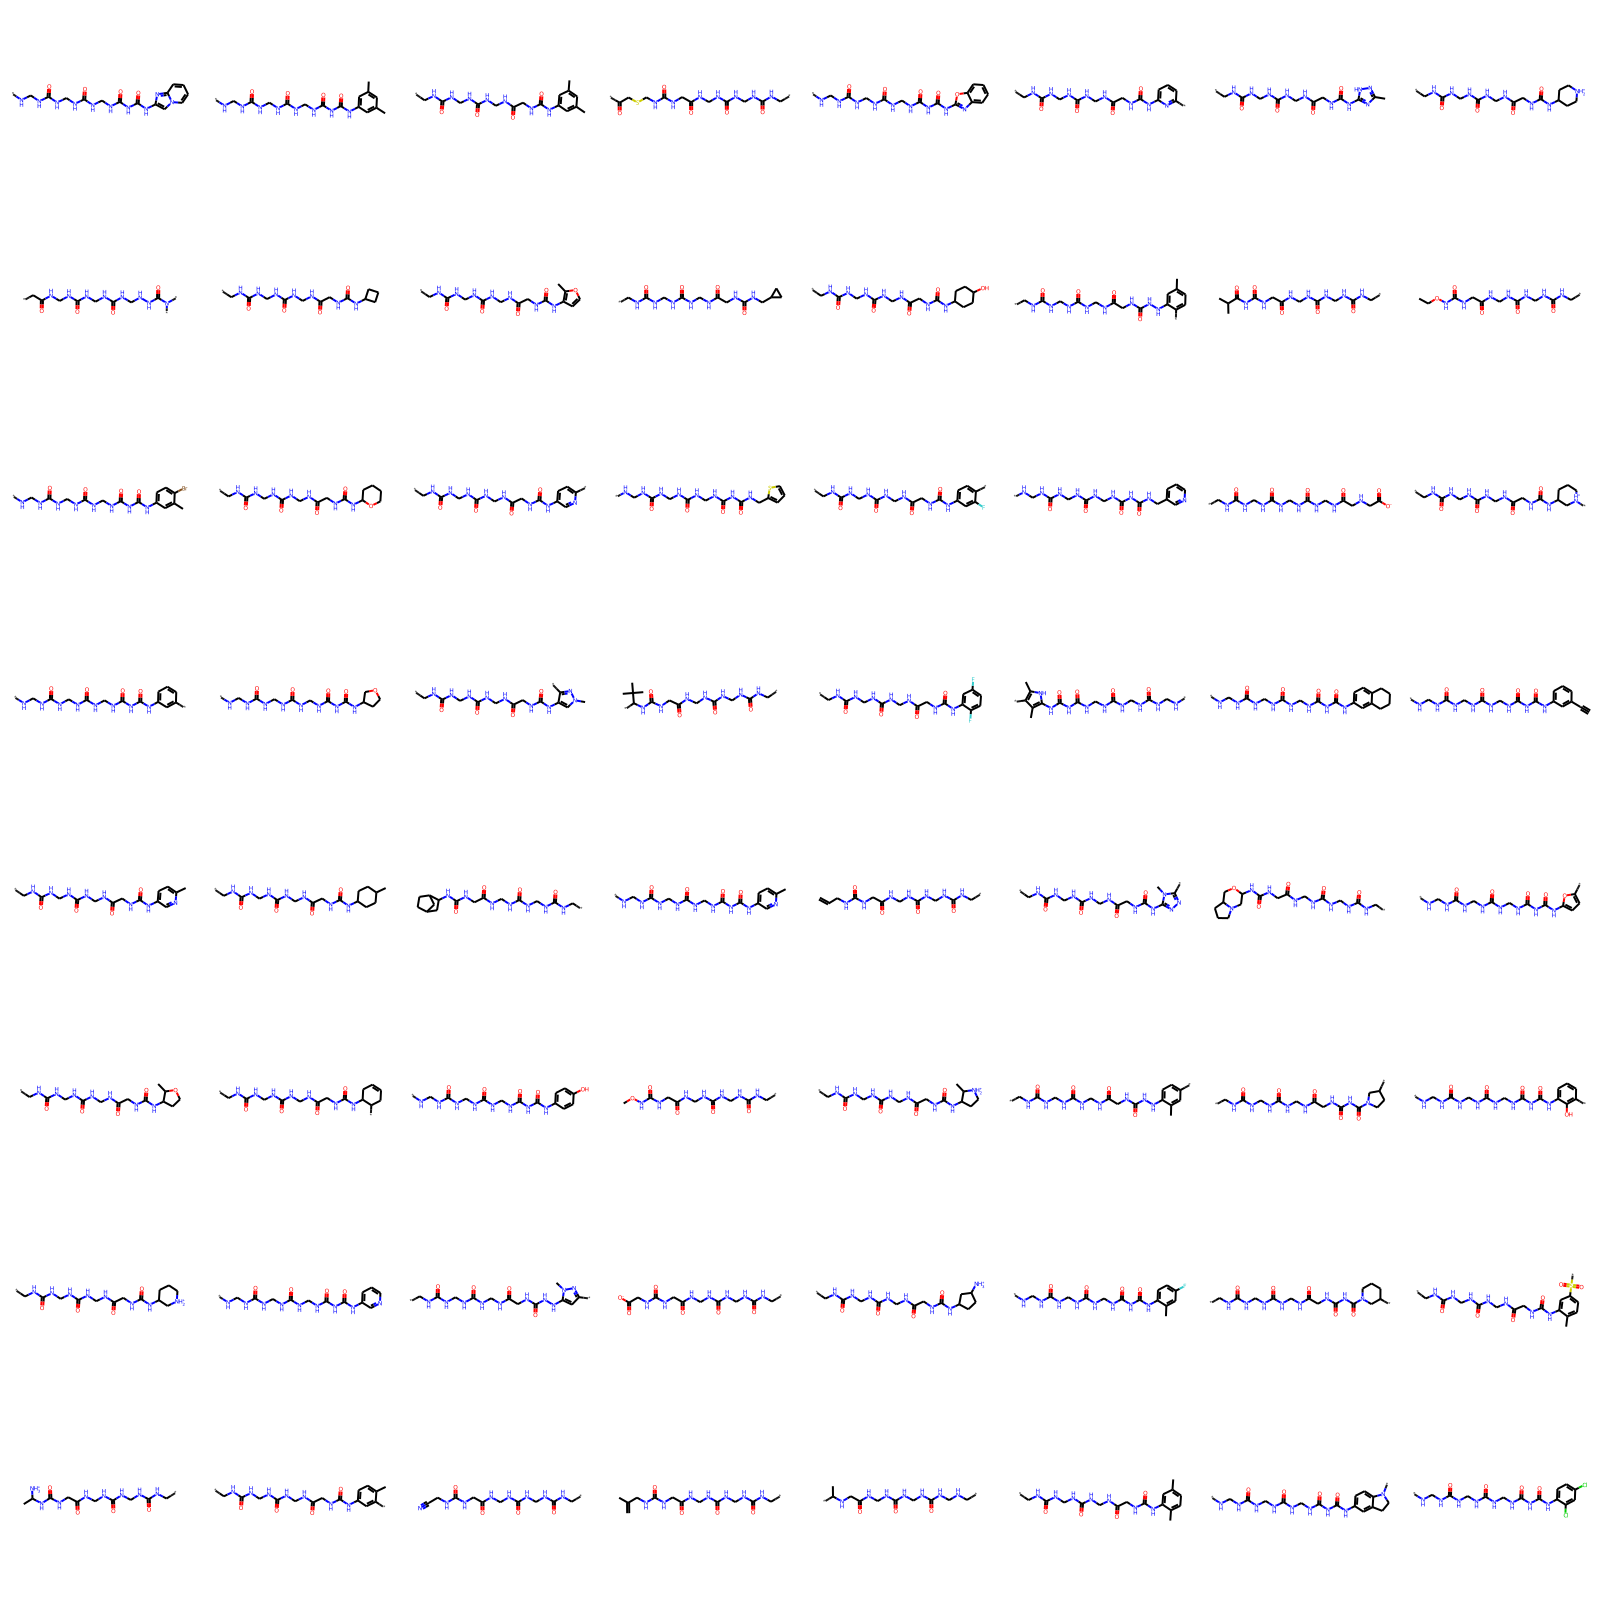

In [92]:
Draw.MolsToGridImage(mols_from_smiles(mol_list_rand), molsPerRow=8, maxMols=999999)

# Plot Sampled Latent Space

In [50]:
x = z_sampled_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

AttributeError: 'list' object has no attribute 'cpu'

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_pred[0:10000]))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
plt.title('Predicted SAS PCA Plot')
#plt.savefig(file_dir + 'Predicted_SAS_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_true),
            vmin = 1, vmax = 7)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
plt.title('True SAS PCA Plot')
#plt.savefig(file_dir + 'True_SAS_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_pred[0:10000]),
            vmin = -2, vmax = 5)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
plt.title('Predicted logp PCA Plot')
#plt.savefig(file_dir + 'Predicted_logp_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_true),
            vmin = 1, vmax = 4)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
plt.title('True logp PCA Plot')
#plt.savefig(file_dir + 'True_logp_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(qed_sampled_true))
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.box(on=None)
plt.title('True QED PCA Plot')
#plt.savefig(file_dir + 'True_QED_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
x_enc = mu_enc_stack.cpu().detach().numpy()
x_enc = StandardScaler().fit_transform(x_enc)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_enc)
principalDf_enc = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf_enc['pc1'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_true),
            vmin = 1, vmax = 6)
plt.xlabel("PC1 sampled", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC1 encoded", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('True SAS PCA Plot')
plt.savefig(file_dir + 'True_SAS_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '_sampled_encoded.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf_enc['pc1'].to_numpy(),  
            alpha=0.5, 
            c=np.array(logp_sampled_true),
            vmin = -2, vmax = 4)
plt.xlabel("PC1 sampled", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC1 encoded", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('True logp PCA Plot')
plt.savefig(file_dir + 'True_logp_PCA_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '_sampled_encoded.png')
plt.show()

In [ ]:
data_box = pd.DataFrame(list(zip(sas_sampled_pred, sas_sampled_true, logp_sampled_pred, logp_sampled_true, qed_sampled_true)), columns=['Predicted SAS','True SAS', 'Predicted LogP', 'True LogP', 'True QED'])
data_box

In [ ]:
fig, ax1 = plt.subplots(figsize=(2, 5))
data_box.boxplot(column=['Predicted SAS'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'Predicted_SAS_Box_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True SAS'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_SAS_Box_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['Predicted LogP'])
plt.yticks(fontsize=15)
plt.ylabel('Property Value', fontsize = 20)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'Predicted_LogP_Box_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True LogP'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_LogP_Box_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(2, 5))
ax1 = data_box.boxplot(column=['True QED'])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(file_dir + 'True_QED_Box_Plot_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

# Sample from prior keeping all points

In [ ]:
def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [ ]:
sample_size = 10000
sample_std = 1

In [ ]:
# Sampling from the prior
z_sampled_stack_all = []
logp_sampled_pred_all = []
sas_sampled_pred_all = []
max_length = config.get('max_length')
temperature = config.get('temperature')
batch_size = 1
counter = 0
with torch.no_grad():
    while len(z_sampled_stack_all)<sample_size:
        model_vae = model.cpu()
        model_vae.eval()
        z = torch.normal(0, sample_std, size=(1, batch_size, 100))
        model = model.cuda()
        pred_logp, pred_sas = model.mlp(z.cuda())
        logp_sampled_pred_all.append(pred_logp.item())
        sas_sampled_pred_all.append(pred_sas.item())
        if len(z_sampled_stack_all) == 0:
            #mu_sampled_stack = mu[None, :]
            z_sampled_stack_all = z[0][i][None, :]
        else:
            #mu_sampled_stack = torch.cat((mu_sampled_stack, mu[None, :]),0)
            z_sampled_stack_all = torch.cat((z_sampled_stack_all, z[0][i][None, :]),0)
        counter += 1
        #break
        if counter % 500 ==0:
            print(len(z_sampled_stack_all))

In [ ]:
#Save Sampled Molecules
torch.save(z_sampled_stack_all.detach(), file_dir + 'z_sampled_stack_tensor_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_pred_all_pd = pd.DataFrame(logp_sampled_pred_all)
logp_sampled_pred_all_pd.to_csv(file_dir + 'logp_sampled_pred_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)
sas_sampled_pred_all_pd = pd.DataFrame(sas_sampled_pred_all)
sas_sampled_pred_all_pd.to_csv(file_dir + 'sas_sampled_pred_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv', index=False)

In [ ]:
z_sampled_stack_all = torch.load(file_dir + 'z_sampled_stack_tensor_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.pt')
logp_sampled_pred_all = list(pd.read_csv(file_dir + 'logp_sampled_pred_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])
sas_sampled_pred_all = list(pd.read_csv(file_dir + 'sas_sampled_pred_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.csv')['0'])

In [ ]:
x = z_sampled_stack_all.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(sas_sampled_pred_all),
            vmin = 1, vmax = 10)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('Predicted SAS PCA Plot')
plt.savefig(file_dir + 'Predicted_SAS_PCA_Plot_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            alpha=0.5, 
            c=np.array(logp_sampled_pred_all),
            vmin = -2, vmax = 10)
plt.xlabel("PC1", fontsize=24)
plt.xticks(fontsize=20)
plt.ylabel("PC2", fontsize=24)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.box(on=None)
#plt.title('Predicted logp PCA Plot')
plt.savefig(file_dir + 'Predicted_logp_PCA_Plot_all_n_0_' + str(sample_std) + '_' + str(sample_size) + '.png')
plt.show()

# Moving in the latent space

In [ ]:
def sample_molecule(z_test):
    state = model.latent2rnn(z_test)
    state = state.view(model.hidden_layers, 1, model.hidden_size)
    # all idx of batch
    sequence_idx = torch.arange(0, 1).long()

    # all idx of batch which are still generating
    running = torch.arange(0, 1).long()
    sequence_mask = torch.ones(1, dtype=torch.bool)

    # idx of still generating sequences
    # with respect to current loop
    running_seqs = torch.arange(0, 1).long()
    lengths = [1] * 1

    generated = torch.Tensor(1, max_length).long()
    generated.fill_(vocab.PAD)

    inputs = Variable(torch.Tensor(1).long())
    inputs.fill_(vocab.SOS).long()
    step = 0
    while(step < max_length and len(running_seqs) > 0):
        inputs = inputs.unsqueeze(1)
        emb = model.embedder(inputs)
        scores, state = model.decoder(emb, state, lengths)
        scores = scores.squeeze(1)

        probs = F.softmax(scores / temperature, dim=1)
        inputs = torch.argmax(probs, 1).reshape(1, -1)

        # save next input
        generated = update(generated, inputs, running, step)
        # update global running sequence
        sequence_mask[running] = (inputs != vocab.EOS)
        running = sequence_idx.masked_select(sequence_mask)

        # update local running sequences
        running_mask = (inputs != vocab.EOS)
        running_seqs = running_seqs.masked_select(running_mask)

        # prune input and hidden state according to local update
        run_length = len(running_seqs)
        if run_length > 0:
            inputs = inputs.squeeze(0)
            inputs = inputs[running_seqs]
            state = state[:, running_seqs]
            running_seqs = torch.arange(0, run_length).long()

        lengths = [1] * run_length
        step += 1
    new_samples = generated.numpy()
    #print(new_samples)
    mask = np.apply_along_axis(row_filter, 1, new_samples)
    return new_samples

def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to
def row_filter(row):
    return (row == vocab.EOS).any()

In [ ]:
mol_graph_list = mols_from_smiles(mol_list)

In [ ]:
mol_list[9]

In [ ]:
mol_graph_list[9]

In [ ]:
z_linspace = torch.linspace(-6, 6, steps=13)
z_linspace

In [ ]:
z_mol = z_sampled_stack[9]
z_mol

In [ ]:
ind_1 = random.randint(0, len(z_mol) - 1)
print("Random Index 1:", ind_1)
ind_2 = random.randint(0, len(z_mol) - 1)
print("Random Index 2:", ind_2)

In [ ]:
for idx, (z_step) in enumerate(z_linspace):
    for idx_2, (z_step_2) in enumerate(z_linspace):
        z_add = torch.zeros(len(z_mol))
        z_add_2 = torch.zeros(len(z_mol))
        z_add[ind_1] += z_step
        z_add_2[ind_2] += z_step_2
        z_search = z_mol + z_add + z_add_2
        if idx_2 == 0:
            z_stack_2 = z_search[None,:]
        else:
            z_stack_2 = torch.cat((z_stack_2,z_search[None,:]),0)
    
    if idx == 0:
        z_stack = z_stack_2[None,:]
    else:
        z_stack = torch.cat((z_stack, z_stack_2[None,:]), 0)

In [ ]:
all(z_stack[5,5]==z_mol)

In [ ]:
new_samples = sample_molecule(z_mol)
frags = mols_from_smiles(vocab.translate(new_samples[i]))
mol = join_molecules(frags[0], frags[1])
for i, frag in enumerate(frags[2:]):
    mol = join_molecules(mol, frag)

In [ ]:
mol

In [ ]:
mol_list = []
max_length = config.get('max_length')
temperature = config.get('temperature')
model = model.cpu()
counter = 0
for z_stack_row in z_stack:
    for z_stack_i in z_stack_row:
        print(counter)
        print(all(z_stack_i==z_mol))
        new_samples = sample_molecule(z_stack_i)
        frags = mols_from_smiles(vocab.translate(new_samples[i]))
        counter += 1
        try:
            mol = join_molecules(frags[0], frags[1])
            for i, frag in enumerate(frags[2:]):
                mol = join_molecules(mol, frag)
            mol_list.append(mol)
        except:
            mol_list.append(mol_list[-1])

In [ ]:
Draw.MolsToGridImage(mol_list, molsPerRow=13, maxMols=999999)

# Check Reconstruction

In [ ]:
dataset.data

In [ ]:
# Sampling from the prior
mol_list = []
frag_list = []
max_length = config.get('max_length')
temperature = config.get('temperature')
batch_size = 1
counter = 0
with torch.no_grad():
    for z in tqdm(z_stack):
        model_vae = model.cpu()
        model_vae.eval()
        samples, sampled = [], 0
        z = z.cpu()
        #z = model.encoder.sample_normal(1).cpu()
        #z = torch.normal(0, sample_std, size=(1, batch_size, 100))
        #z = mu_stack[10,None,None].cpu()
        #z = mu[None, None, :].cpu()
        state = model_vae.latent2rnn(z)
        state = state.view(model_vae.hidden_layers, batch_size, model_vae.hidden_size)
        # all idx of batch
        sequence_idx = torch.arange(0, batch_size).long()

        # all idx of batch which are still generating
        running = torch.arange(0, batch_size).long()
        sequence_mask = torch.ones(batch_size, dtype=torch.bool)

        # idx of still generating sequences
        # with respect to current loop
        running_seqs = torch.arange(0, 1).long()
        lengths = [1] * batch_size

        generated = torch.Tensor(batch_size, max_length).long()
        generated.fill_(vocab.PAD)

        inputs = Variable(torch.Tensor(batch_size).long())
        inputs.fill_(vocab.SOS).long()
        step = 0
        while(step < max_length and len(running_seqs) > 0):
            inputs = inputs.unsqueeze(1)
            emb = model_vae.embedder(inputs)
            scores, state = model_vae.decoder(emb, state, lengths)
            scores = scores.squeeze(1)

            probs = F.softmax(scores / temperature, dim=1)
            inputs = torch.argmax(probs, 1).reshape(1, -1)

            # save next input
            generated = update(generated, inputs, running, step)
            # update global running sequence
            sequence_mask[running] = (inputs != vocab.EOS)
            running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (inputs != vocab.EOS)
            running_seqs = ~running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            run_length = len(running_seqs)
            if run_length > 0:
                inputs = inputs.squeeze(0)
                inputs = inputs[running_seqs]
                state = state[:, running_seqs]
                running_seqs = torch.arange(0, run_length).long()

            lengths = [1] * run_length
            step += 1
        new_samples_torch = generated
        new_samples = generated.numpy()
        #print(vocab.translate(new_samples[i]))
        mask = np.apply_along_axis(row_filter, 1, new_samples)
        #save molecule
            
        try:
            frags = mols_from_smiles(vocab.translate(new_samples[i]))
            mol = join_molecules(frags[0], frags[1])
            for j, frag in enumerate(frags[2:]):
                #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
                mol = join_molecules(mol, frag)
                #print(i, mol_to_smiles(mol))
                mol = mols_from_smiles(mols_to_smiles([mol]))[0]
            model = model.cuda()

            # Store fragments and molecule sampled from the sampled z
            frag_list.append(vocab.translate(new_samples[i]))
            mol_list.append(mol)
        except:
            frag_list.append([None])
            mol_list.append(None)

        counter += 1
        if counter % 500 ==0:
            print(len(mol_list))
            #break
        if counter % 2000 == 0:
            clear_output(wait=True)

In [ ]:
mol_smi_list = []
for mol in tqdm(mol_list):
    if mol == None:
        mol_smi_list.append(None)
    else:
        mol_smi = mols_to_smiles([mol])[0]
        mol_smi_list.append(mol_smi)

In [ ]:
mol_smi_list

In [ ]:
smi_training_list = dataset.data.smiles.to_list()
smi_training_list

In [ ]:
equiv_mol = []
for i in tqdm(range(len(mol_smi_list))):
    if mol_smi_list[i]==smi_training_list[i]:
        equiv_mol.append(True).append(True)
    else:
        equiv_mol.append(False)

In [ ]:
print(all(item is False for item in equiv_mol))

No molecule is correctly reconstructed by the decoder

# Some example molecules

In [ ]:
mols_from_smiles(['C(O)C'])[0]

In [ ]:
mol = join_molecules(frags[0], frags[1])
for i, frag in enumerate(frags[2:]):
    #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
    mol = join_molecules(mol, frag)
    #print(i, mol_to_smiles(mol))

In [ ]:
mol = mols_from_smiles(mols_to_smiles([mol]))[0]

In [ ]:
mol

In [ ]:
print("logP: ", Crippen.MolLogP(mol))
print("MR: ", Crippen.MolMR(mol))
print("QED: ", QED.qed(mol))
print("SAS: ", calculateScore(mol))

In [ ]:
model = model.cuda()
vec_frag_sum = torch.sum(model.embedder(torch.tensor(new_samples).cuda()[torch.tensor(new_samples).cuda() > 2]), 0)
z, mu, sigma = model.encoder(vec_frag_sum)
pred_logp = model.mlp(mu)
pred_logp

In [ ]:
fragment_list = []
for frag in tqdm(dataset.data.fragments):
    fragment_list.extend(frag.split())
fragment_counts = pd.Series(fragment_list).value_counts()
fragment_counts = fragment_counts.append(pd.Series(len(dataset.data)))
penalty = np.sum(np.log(fragment_counts + 1)) / np.log(fragment_counts + 1)
penalty_weights = penalty / np.linalg.norm(penalty)

In [ ]:
fragment_counts

In [ ]:
penalty_weights*1000